In [166]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.driver.memory", "15g") \
    .appName("MelbournePedistrian") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
import math

oversampling = True
train_part_num = 10
test_part_num = 1
k = 1
in_k = max(math.floor(k/train_part_num), 1)

In [167]:
if not oversampling:
    # df = spark.read.csv("abfss://team6@sauondbrwebigdatalrs1.dfs.core.windows.net/ECG5000/ECG5000_TRAIN.tsv",sep=r'\t', header=True)
    train_df = spark.read.csv("../data/ECG5000/ECG5000_TRAIN.tsv", sep='\t', header=False)
    test_df = spark.read.csv("../data/ECG5000/ECG5000_TEST.tsv" ,sep='\t', header=False)

In [168]:
from pyspark.sql.functions import rand

if not oversampling:
    train_df = train_df.orderBy(rand()) #.limit(100)
    test_df = test_df.orderBy(rand()) #.limit(15)

In [169]:
from pyspark.sql.functions import col

if not oversampling:
    train_df = train_df.withColumnRenamed("_c0", "Class")
    test_df = test_df.withColumnRenamed("_c0", "Class")

    for col_name in train_df.columns[1:]:
        if col_name != "Class":
            train_df = train_df.withColumn(col_name, col(col_name).cast("float"))

    for col_name in test_df.columns[1:]:
        if col_name != "Class":
            test_df = test_df.withColumn(col_name, col(col_name).cast("float"))

    # Append the rows from test_df to train_df
    merged_df = train_df.union(test_df) 

In [170]:
if oversampling:
    merged_df = spark.read.csv("../data/ECG5000/ECG5000_Oversampled.csv", header=True)
    merged_df = merged_df.orderBy(rand(seed=42))

# Show the resulting dataframe
merged_df.count()

5000

In [ ]:
merged_df = merged_df.limit(1000)

In [171]:
merged_df.show(5)

+-----+----------+----------+-----------+----------+----------+----------+----------+-----------+-----------+-----------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+-----------+------------+------------+-----------+-------------+-----------+------------+-----------+----------+----------+-----------+----------+-----------+----------+-----------+-----------+------------+-----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----

In [172]:
# Define the split ratio
train_ratio = 0.7
test_ratio = 0.3

# Split the data into train and test sets
train_df, test_df = merged_df.randomSplit([train_ratio, test_ratio], seed=346)

In [173]:
train_df.groupBy("Class").count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    3|   66|
|    5|   16|
|    1| 2049|
|    4|  140|
|    2| 1224|
+-----+-----+



In [174]:
train_df.count()

3495

In [175]:
# train_df.cache()
# test_df.cache()

In [176]:
# for df in [train_df, test_df]:
#     duplicates_df = df.dropDuplicates()
#     num_duplicates = df.count() - duplicates_df.count()
#     if num_duplicates > 0:
#         print("There are duplicate rows in the DataFrame.")
#     else:
#         print("There are no duplicate rows in the DataFrame.")

In [177]:
import pyspark.sql.functions as F
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import numpy as np
import pandas as pd
import math

In [178]:
train_part_num = 10
test_part_num = 10
k = 10
in_k = max(math.floor(k/train_part_num), 1)

In [179]:
from pyspark.sql.functions import array, col, lit

# Determine the number of columns in each partition
num_cols = len(train_df.columns) - 1 # excluding 'Class'
cols_per_part = num_cols // train_part_num
cols_remainder = num_cols % train_part_num

print("TOTAL COLS NUM:", num_cols)
print("COLUMNS PER PARTITION:", cols_per_part)
print("REMAINDER:", cols_remainder)

# Split the columns into equal subsets
col_subsets = []
start_idx = 1
for i in range(train_part_num):
    # Determine the number of columns in this partition
    if i < cols_remainder:
        num_part_cols = cols_per_part + 1
    else:
        num_part_cols = cols_per_part

    print("PARTITION", i, "HAS", num_part_cols, "COLUMNS")

    # Select the columns for this partition and add the 'Class' column
    partition_cols = train_df.columns[start_idx:start_idx+num_part_cols] + ['Class']
    col_subsets.append(partition_cols)

    # Update the starting index for the next partition
    start_idx += num_part_cols

# Split the original dataframe into multiple dataframes
dfs = []
for n, subset in enumerate(col_subsets):
    partition_ids = [22,0,4,1,2,23,5,7,13,6]
    df = train_df.select(subset)
    for i, column in enumerate(df.columns):
        df = df.withColumnRenamed(column, col_subsets[0][i])
    df = df.withColumn('partition_id', lit(partition_ids[n]))
    dfs.append(df)

# Vertically stack the dataframes to create a single dataframe
result = dfs[0]
for i in range(1, len(dfs)):
    result = result.unionByName(dfs[i])

result.groupBy("partition_id").count().show()

# Partition the DataFrame by the 'partition_id' column
train_df_part = result.repartition(train_part_num, "partition_id")

TOTAL COLS NUM: 140
COLUMNS PER PARTITION: 14
REMAINDER: 0
PARTITION 0 HAS 14 COLUMNS
PARTITION 1 HAS 14 COLUMNS
PARTITION 2 HAS 14 COLUMNS
PARTITION 3 HAS 14 COLUMNS
PARTITION 4 HAS 14 COLUMNS
PARTITION 5 HAS 14 COLUMNS
PARTITION 6 HAS 14 COLUMNS
PARTITION 7 HAS 14 COLUMNS
PARTITION 8 HAS 14 COLUMNS
PARTITION 9 HAS 14 COLUMNS


23/05/11 14:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1096.0 KiB


+------------+-----+
|partition_id|count|
+------------+-----+
|          22| 3504|
|           0| 3504|
|           4| 3504|
|           1| 3504|
|           2| 3504|
|          23| 3504|
|           5| 3504|
|           7| 3504|
|          13| 3504|
|           6| 3504|
+------------+-----+



In [180]:
train_rdd = train_df_part.rdd

# Check the number of partitions
num_partitions = train_rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Check the shape of each partition
partition_shapes = train_rdd.mapPartitions(lambda iterator: [len(list(iterator))]).collect()
print(f"Shape of each partition: {partition_shapes}")

Number of partitions: 10
Shape of each partition: [3504, 3504, 3504, 3504, 3504, 3504, 3504, 3504, 3504, 3504]


In [181]:
column_names = train_df_part.columns
def toPandas_partition(instances):
    panda_df = pd.DataFrame(columns = column_names)      # using the global variable
    
    for instance in instances:  # each instance is of Row type
        panda_df = pd.concat([panda_df, pd.DataFrame([instance.asDict()])], ignore_index=True)
  
    return [panda_df]

rdd_pandas = train_rdd.mapPartitions(toPandas_partition)

In [182]:
import random

def build_model(partition):

    knn = KNeighborsTimeSeriesClassifier(n_neighbors=in_k, metric='dtw')
    
    X_train = partition.drop('Class', axis=1)
    y_train = partition['Class']
    
    model = knn.fit(X_train, y_train)

    return (model, partition['partition_id'][0])

model_list = rdd_pandas.map(build_model).collect()

In [183]:
# Determine the number of columns in each partition
num_cols = len(test_df.columns) - 1 # excluding 'Class'
cols_per_part = num_cols // test_part_num
cols_remainder = num_cols % test_part_num

print("TOTAL COLS NUM:", num_cols)
print("COLUMNS PER PARTITION:", cols_per_part)
print("REMAINDER:", cols_remainder)

# Split the columns into equal subsets
col_subsets = []
start_idx = 1
for i in range(test_part_num):
    # Determine the number of columns in this partition
    if i < cols_remainder:
        num_part_cols = cols_per_part + 1
    else:
        num_part_cols = cols_per_part

    print("PARTITION", i, "HAS", num_part_cols, "COLUMNS")

    # Select the columns for this partition and add the 'Class' column
    partition_cols = test_df.columns[start_idx:start_idx+num_part_cols] + ['Class']
    col_subsets.append(partition_cols)

    # Update the starting index for the next partition
    start_idx += num_part_cols

# Split the original dataframe into multiple dataframes
dfs = []
for n, subset in enumerate(col_subsets):
    partition_ids = [22,0,4,1,2,23,5,7,13,6]
    df = test_df.select(subset)
    for i, column in enumerate(df.columns):
        df = df.withColumnRenamed(column, col_subsets[0][i])
    df = df.withColumn('partition_id', lit(partition_ids[n]))
    dfs.append(df)

# Vertically stack the dataframes to create a single dataframe
result = dfs[0]
for i in range(1, len(dfs)):
    result = result.unionByName(dfs[i])

result.groupBy("partition_id").count().show()

# Partition the DataFrame by the 'partition_id' column
test_df_part = result.repartition(test_part_num, "partition_id")

TOTAL COLS NUM: 140
COLUMNS PER PARTITION: 14
REMAINDER: 0
PARTITION 0 HAS 14 COLUMNS
PARTITION 1 HAS 14 COLUMNS
PARTITION 2 HAS 14 COLUMNS
PARTITION 3 HAS 14 COLUMNS
PARTITION 4 HAS 14 COLUMNS
PARTITION 5 HAS 14 COLUMNS
PARTITION 6 HAS 14 COLUMNS
PARTITION 7 HAS 14 COLUMNS
PARTITION 8 HAS 14 COLUMNS
PARTITION 9 HAS 14 COLUMNS


23/05/11 14:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1096.0 KiB


+------------+-----+
|partition_id|count|
+------------+-----+
|          22| 1496|
|           0| 1496|
|           4| 1496|
|           1| 1496|
|           2| 1496|
|          23| 1496|
|           5| 1496|
|           7| 1496|
|          13| 1496|
|           6| 1496|
+------------+-----+



In [184]:
test_rdd = test_df_part.rdd

# Check the number of partitions
num_partitions = test_rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

# Check the shape of each partition
partition_shapes = test_rdd.mapPartitions(lambda iterator: [len(list(iterator))]).collect()
print(f"Shape of each partition: {partition_shapes}")

Number of partitions: 10
Shape of each partition: [1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496]


In [185]:
# !pip install h5py
import numpy as np

def make_predictions(row):

    pred, dist = None, None

    np_array = np.array(list(row))
    # print("MAKING PREDICTION 0")
    partition_id = int(np_array[-1])
    # print("MAKING PREDICTION 1")
    X = np_array[:-2]

    for m in model_list:
        if m[1] == partition_id:
            # print("MAKING PREDICTION")
            neighbors = m[0].kneighbors(np.array([X]).astype(float))
            # print(1)
            pred = m[0].predict(np.array([X]).astype(float)).tolist()
            # print(2)
            dist = neighbors[0].tolist()

    # print(pred, dist)

    return pred, dist, partition_id

def make_predictions_partition(partition):
    # make predictions for all rows in the partition in parallel
    pred = map(make_predictions, partition)
    return pred


partition_predictions = test_rdd.mapPartitions(make_predictions_partition)

# collect the predictions for all partitions into a single list
all_predictions = partition_predictions.collect()

print(all_predictions)



[(['1'], [[41.674296584242214]], 22), (['1'], [[52.45249160681248]], 22), (['1'], [[19.19089849037535]], 22), (['1'], [[16.638688151156675]], 22), (['1'], [[9.105807529071933]], 22), (['1'], [[23.922659964489007]], 22), (['1'], [[15.753322920145331]], 22), (['1'], [[10.72881869757251]], 22), (['1'], [[10.023268011502996]], 22), (['1'], [[6.261502012578788]], 22), (['2'], [[9.389642673505453]], 22), (['2'], [[7.067085999726498]], 22), (['2'], [[26.66218023956884]], 22), (['2'], [[4.470429590950009]], 22), (['2'], [[7.506660993798184]], 22), (['1'], [[25.435527362527917]], 22), (['1'], [[10.979509457148902]], 22), (['1'], [[18.367038926272716]], 22), (['1'], [[25.137400677664512]], 22), (['1'], [[54.095353580551]], 22), (['1'], [[11.380435271309002]], 22), (['1'], [[12.658788135820174]], 22), (['1'], [[10.871905162565616]], 22), (['2'], [[28.253647329859863]], 22), (['2'], [[24.34477050263047]], 22), (['2'], [[13.214028988893288]], 22), (['2'], [[13.685132434168446]], 22), (['2'], [[4.20

In [186]:
# group by third element
grouped_rdd = partition_predictions.groupBy(lambda x: x[2])

# collect and print results
for group in grouped_rdd.collect():
    print(f"Group {group[0]}:")
    for value in group[1]:
        print(value)

Group 0:
(['1'], [[39.69950754056692]], 0)
(['1'], [[47.905221029789296]], 0)
(['1'], [[17.72590006348597]], 0)
(['1'], [[9.32007547221477]], 0)
(['1'], [[17.18798006548347]], 0)
(['1'], [[13.304488374251818]], 0)
(['1'], [[19.44696958282253]], 0)
(['1'], [[2.883439196494957]], 0)
(['1'], [[8.32396753696327]], 0)
(['1'], [[46.767591766669604]], 0)
(['3'], [[6.640821140893102]], 0)
(['1'], [[1.839891133969109]], 0)
(['2'], [[7.0583425747071145]], 0)
(['2'], [[8.80903195261774]], 0)
(['2'], [[2.9705606288340736]], 0)
(['2'], [[20.33870089538522]], 0)
(['1'], [[5.304633394598664]], 0)
(['2'], [[15.048240621259145]], 0)
(['1'], [[13.322851125061646]], 0)
(['2'], [[2.266412196278826]], 0)
(['1'], [[8.311269772402152]], 0)
(['1'], [[7.366224711025505]], 0)
(['5'], [[1.313377146382643]], 0)
(['2'], [[0.6469870264828105]], 0)
(['2'], [[1.2420910318732246]], 0)
(['2'], [[3.490681303256695]], 0)
(['2'], [[8.43336586458294]], 0)
(['1'], [[51.67933838351926]], 0)
(['1'], [[6.313837068160177]], 0)


In [187]:
# group by third element
grouped_rdd = partition_predictions.groupBy(lambda x: x[2])

# get a list of tuples with the ith value of each group
grouped_values = list(zip(*[group[1] for group in grouped_rdd.collect()]))

y_pred = []

# define a function to select the top k tuples for each group
def select_top_k(tuples):
    # sort the tuples by the second element
    sorted_tuples = sorted(tuples, key=lambda x: x[1])
    # select the top k tuples with the lowest second element
    top_k_tuples = sorted_tuples[:k]
    return top_k_tuples

from collections import Counter

# print the grouped values with the top k tuples for each group
for i, values in enumerate(grouped_values):
    top_k_tuples = select_top_k(values)
    y_pred.append(Counter([t[0][0] for t in top_k_tuples]).most_common(1)[0][0])

print(y_pred)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '1', '1', '1', '1', '2', '1', '1', '1', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1', '2', '2', '2', '3', '2', '2', '4', '1', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',

In [188]:
len(y_pred)

1496

In [189]:
y_test = test_df.select("Class").collect()

In [190]:
from pyspark.sql.functions import when, count

y_pred_df = spark.createDataFrame([(i,) for i in y_pred], ['prediction'])
y_test_df = spark.createDataFrame(y_test, ['Class'])

In [191]:
from pyspark.sql.functions import monotonically_increasing_id

y_pred_df = y_pred_df.withColumn("id", monotonically_increasing_id())
y_test_df = y_test_df.withColumn("id", monotonically_increasing_id())

joined_df = y_pred_df.join(y_test_df, "id", "outer").drop("id")

joined_df = joined_df.withColumn('same_values', when(joined_df.prediction == joined_df.Class, 1).otherwise(0))

print("joined_df:")
joined_df.show(5)

joined_df:
+----------+-----+-----------+
|prediction|Class|same_values|
+----------+-----+-----------+
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
|         1|    1|          1|
+----------+-----+-----------+
only showing top 5 rows



In [192]:
joined_df.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         3|   10|
|      null|    9|
|         1|  885|
|         4|   17|
|         2|  584|
+----------+-----+



In [193]:
percentage_same_values = joined_df.agg({'same_values': 'mean'}).collect()[0][0] * 100

print(f"{percentage_same_values:.2f}% of rows have the same label and prediction.")

85.18% of rows have the same label and prediction.


In [195]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

indexed_df = joined_df.withColumn("ClassIndex", col("Class").cast("integer"))

# Cast the prediction column to DoubleType
indexed_df = indexed_df.withColumn("prediction", col("prediction").cast("double"))

# Compute F1 score
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="ClassIndex", metricName="f1")
f1_score = evaluator.evaluate(indexed_df)
print(f"F1 score: {f1_score:.2f}")

23/05/11 19:19:48 ERROR Executor: Exception in task 0.0 in stage 1751.0 (TID 2793)
scala.MatchError: [null,1.0,1.0] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.$anonfun$getMetrics$3(MulticlassClassificationEvaluator.scala:204)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:199)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Exec

Py4JJavaError: An error occurred while calling o7973.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1751.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1751.0 (TID 2793) (10.15.176.160 executor driver): scala.MatchError: [null,1.0,1.0] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.$anonfun$getMetrics$3(MulticlassClassificationEvaluator.scala:204)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:199)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:737)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:736)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass$lzycompute(MulticlassMetrics.scala:66)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labelCountByClass(MulticlassMetrics.scala:64)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:227)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure$lzycompute(MulticlassMetrics.scala:235)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.weightedFMeasure(MulticlassMetrics.scala:235)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.evaluate(MulticlassClassificationEvaluator.scala:153)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: scala.MatchError: [null,1.0,1.0] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator.$anonfun$getMetrics$3(MulticlassClassificationEvaluator.scala:204)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:199)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [196]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

indexed_df = indexed_df.withColumn("ClassIndexDb", col("ClassIndex").cast("double"))


In [197]:
indexed_df.printSchema()

root
 |-- prediction: double (nullable = true)
 |-- Class: string (nullable = true)
 |-- same_values: integer (nullable = false)
 |-- ClassIndex: integer (nullable = true)
 |-- ClassIndexDb: double (nullable = true)



In [199]:
# Calculate the confusion matrix
predictions_and_labels = indexed_df.select(["prediction", "ClassIndexDb"]).rdd
metrics = MulticlassMetrics(predictions_and_labels)

In [200]:
confusion_matrix = metrics.confusionMatrix().toArray()

23/05/11 19:20:01 ERROR Executor: Exception in task 0.0 in stage 1765.0 (TID 2828)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/session.py", line 682, in prepare
    verify_

Py4JJavaError: An error occurred while calling o8067.confusionMatrix.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1765.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1765.0 (TID 2828) (10.15.176.160 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/session.py", line 682, in prepare
    verify_func(obj)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1411, in verify
    verify_value(obj)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1392, in verify_struct
    verifier(v)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1410, in verify
    if not verify_nullability(obj):
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1280, in verify_nullability
    raise ValueError(new_msg("This field is not nullable, but got None"))
ValueError: field prediction: This field is not nullable, but got None

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:737)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:736)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions$lzycompute(MulticlassMetrics.scala:61)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusions(MulticlassMetrics.scala:52)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass$lzycompute(MulticlassMetrics.scala:78)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.tpByClass(MulticlassMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels$lzycompute(MulticlassMetrics.scala:241)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.labels(MulticlassMetrics.scala:241)
	at org.apache.spark.mllib.evaluation.MulticlassMetrics.confusionMatrix(MulticlassMetrics.scala:113)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/session.py", line 682, in prepare
    verify_func(obj)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1411, in verify
    verify_value(obj)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1392, in verify_struct
    verifier(v)
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1410, in verify
    if not verify_nullability(obj):
  File "/Users/filip/miniconda3/envs/big2/lib/python3.9/site-packages/pyspark/sql/types.py", line 1280, in verify_nullability
    raise ValueError(new_msg("This field is not nullable, but got None"))
ValueError: field prediction: This field is not nullable, but got None

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:197)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [201]:
# Define list of class labels
classes = ['1', '2', '3', '4', '5']

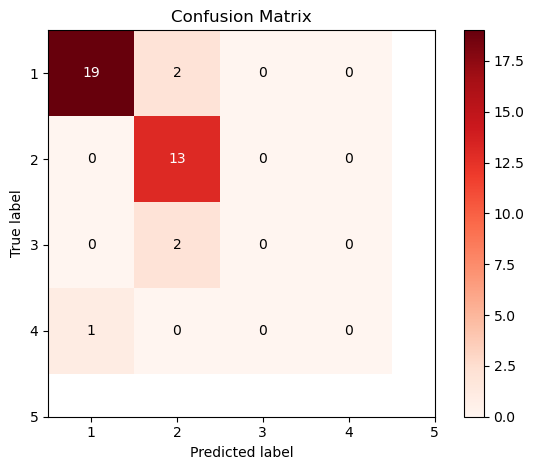

In [202]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Reds')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Loop over data dimensions and create text annotations.
thresh = confusion_matrix.max() / 2.
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.tight_layout()
plt.show()